# Diabetes Prediction Model

This notebook demonstrates the development of a machine learning model to predict diabetes based on the Pima Indians Diabetes Dataset. We'll go through data exploration, visualization, feature analysis, model building, hyperparameter tuning, and model comparison.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
import xgboost as xgb
import joblib
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Data Loading and Exploration

In [4]:
# Load the diabetes dataset
dataset_path = os.path.join('..', 'datasets', 'diabetes', 'pima_diabetes.csv')
data = pd.read_csv(dataset_path)

# Display basic information
print(f"Dataset shape: {data.shape}")
print(f"\nFirst 5 rows:")
display(data.head())

# Check for missing values
print(f"\nMissing values:")
print(data.isnull().sum())

# Display basic statistics
print(f"\nBasic statistics:")
display(data.describe())

Dataset shape: (768, 9)

First 5 rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



Missing values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Basic statistics:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Understanding the Features

The Pima Indians Diabetes Dataset includes the following features:

- **Pregnancies**: Number of times pregnant
- **Glucose**: Plasma glucose concentration (2 hours after an oral glucose tolerance test)
- **BloodPressure**: Diastolic blood pressure (mm Hg)
- **SkinThickness**: Triceps skin fold thickness (mm)
- **Insulin**: 2-Hour serum insulin (mu U/ml)
- **BMI**: Body mass index (weight in kg/(height in m)²)
- **DiabetesPedigreeFunction**: Diabetes pedigree function (a function that scores likelihood of diabetes based on family history)
- **Age**: Age in years
- **Outcome**: Class variable (0 = no diabetes, 1 = diabetes)

In [5]:
# Check for zero values that might represent missing data
zero_counts = (data == 0).sum()
print("Number of zero values in each column:")
print(zero_counts)

# Some columns shouldn't have zeros (physiologically impossible)
print("\nColumns that shouldn't have zeros (physiologically):")
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']:
    print(f"{col}: {(data[col] == 0).sum()} zeros")

Number of zero values in each column:
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

Columns that shouldn't have zeros (physiologically):
Glucose: 5 zeros
BloodPressure: 35 zeros
SkinThickness: 227 zeros
BMI: 11 zeros
Insulin: 374 zeros


Class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64
Percentage of positive cases: 34.90%


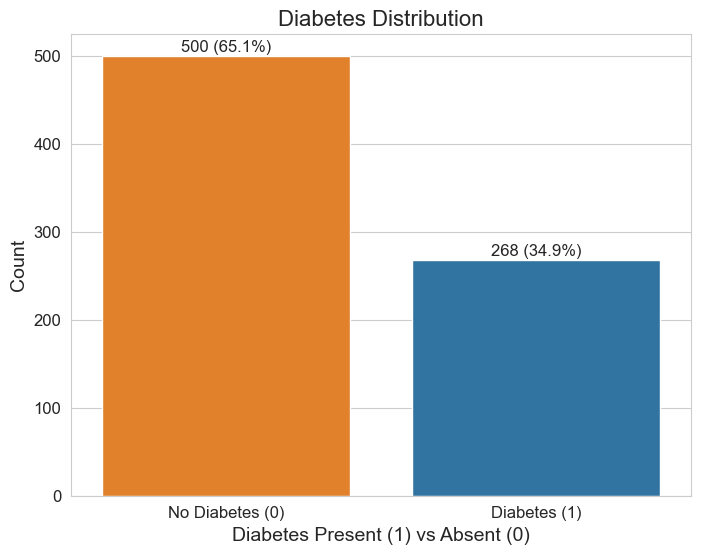

In [6]:
# Check class distribution
target_counts = data['Outcome'].value_counts()
print(f"Class distribution:\n{target_counts}")
print(f"Percentage of positive cases: {target_counts[1]/len(data)*100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=data, palette=['#ff7f0e', '#1f77b4'])
plt.title('Diabetes Distribution', fontsize=16)
plt.xlabel('Diabetes Present (1) vs Absent (0)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['No Diabetes (0)', 'Diabetes (1)'])
for i, count in enumerate(target_counts):
    plt.text(i, count + 5, f"{count} ({count/len(data)*100:.1f}%)", ha='center')
plt.show()

## 2. Data Preprocessing

Let's handle the zero values that likely represent missing data and prepare the dataset for modeling.

In [7]:
# Create a copy of the data for preprocessing
df_clean = data.copy()

# Replace zeros with NaN for columns where zeros are physiologically impossible
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']:
    df_clean[col] = df_clean[col].replace(0, np.nan)

# Check missing values after replacement
print("Missing values after replacing zeros:")
print(df_clean.isnull().sum())

# Fill missing values with median
for col in df_clean.columns[:-1]:  # Exclude the target column
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Verify no missing values remain
print("\nMissing values after imputation:")
print(df_clean.isnull().sum())

# Display statistics after preprocessing
print("\nStatistics after preprocessing:")
display(df_clean.describe())

Missing values after replacing zeros:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Statistics after preprocessing:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 3. Data Visualization

Let's explore the data through various visualizations to better understand the relationships between features and the target variable.

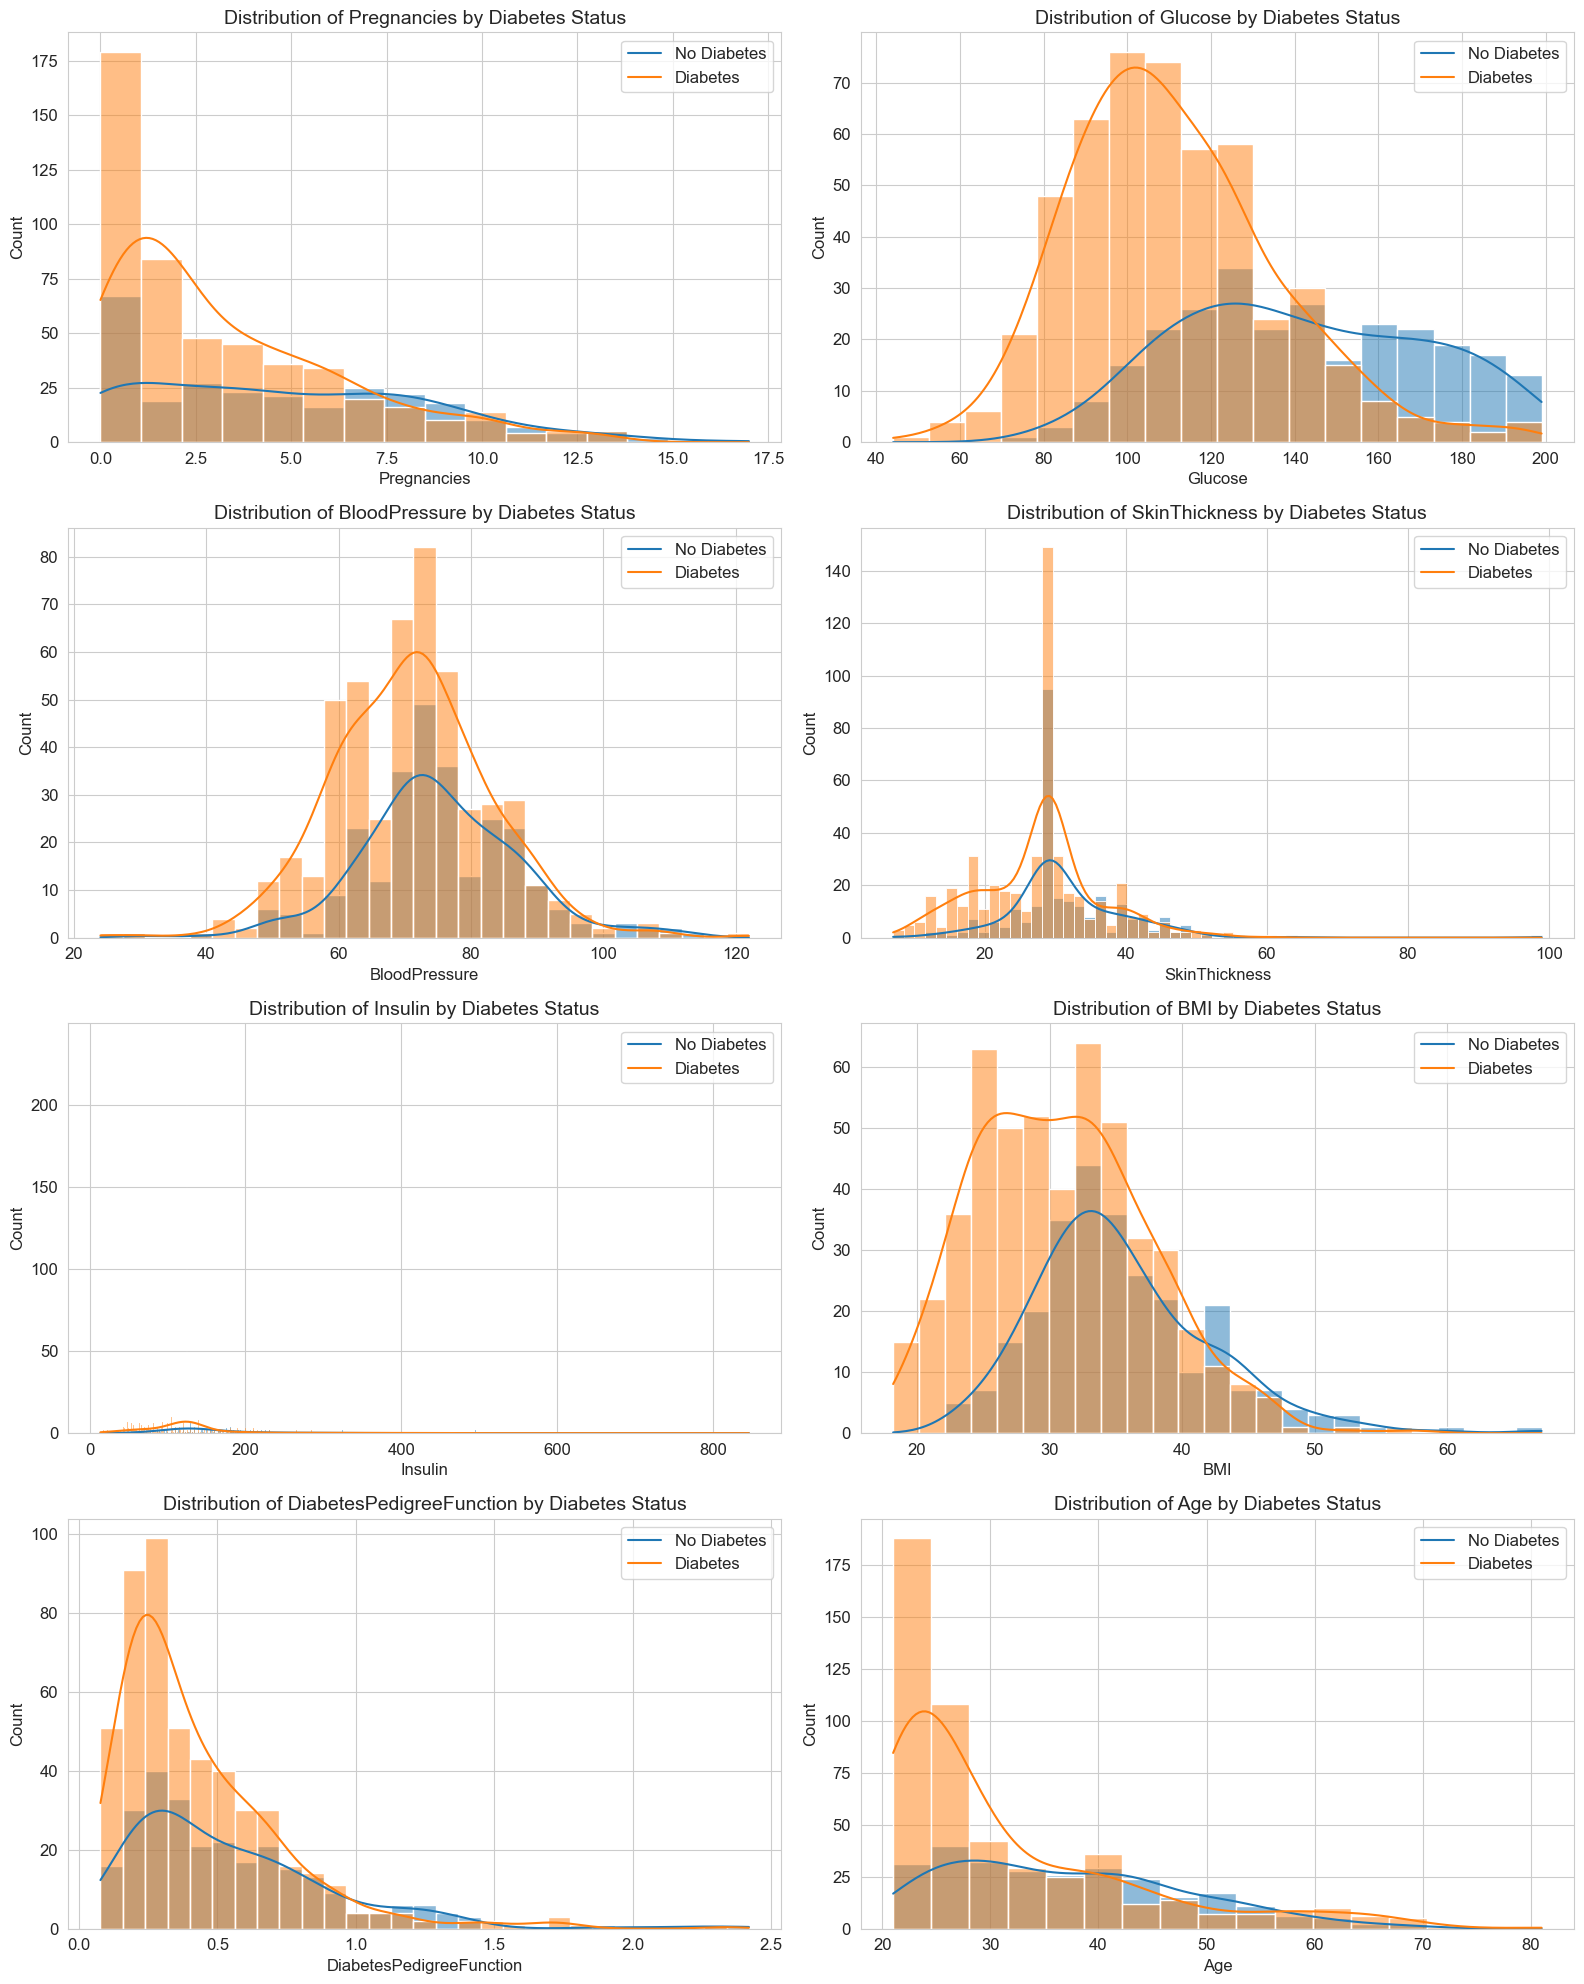

In [8]:
# Distribution of features by diabetes outcome
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(df_clean.columns[:-1]):  # Exclude the target column
    sns.histplot(data=df_clean, x=col, hue='Outcome', kde=True, ax=axes[i], palette=['#ff7f0e', '#1f77b4'])
    axes[i].set_title(f'Distribution of {col} by Diabetes Status', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].legend(['No Diabetes', 'Diabetes'])

plt.tight_layout()
plt.show()

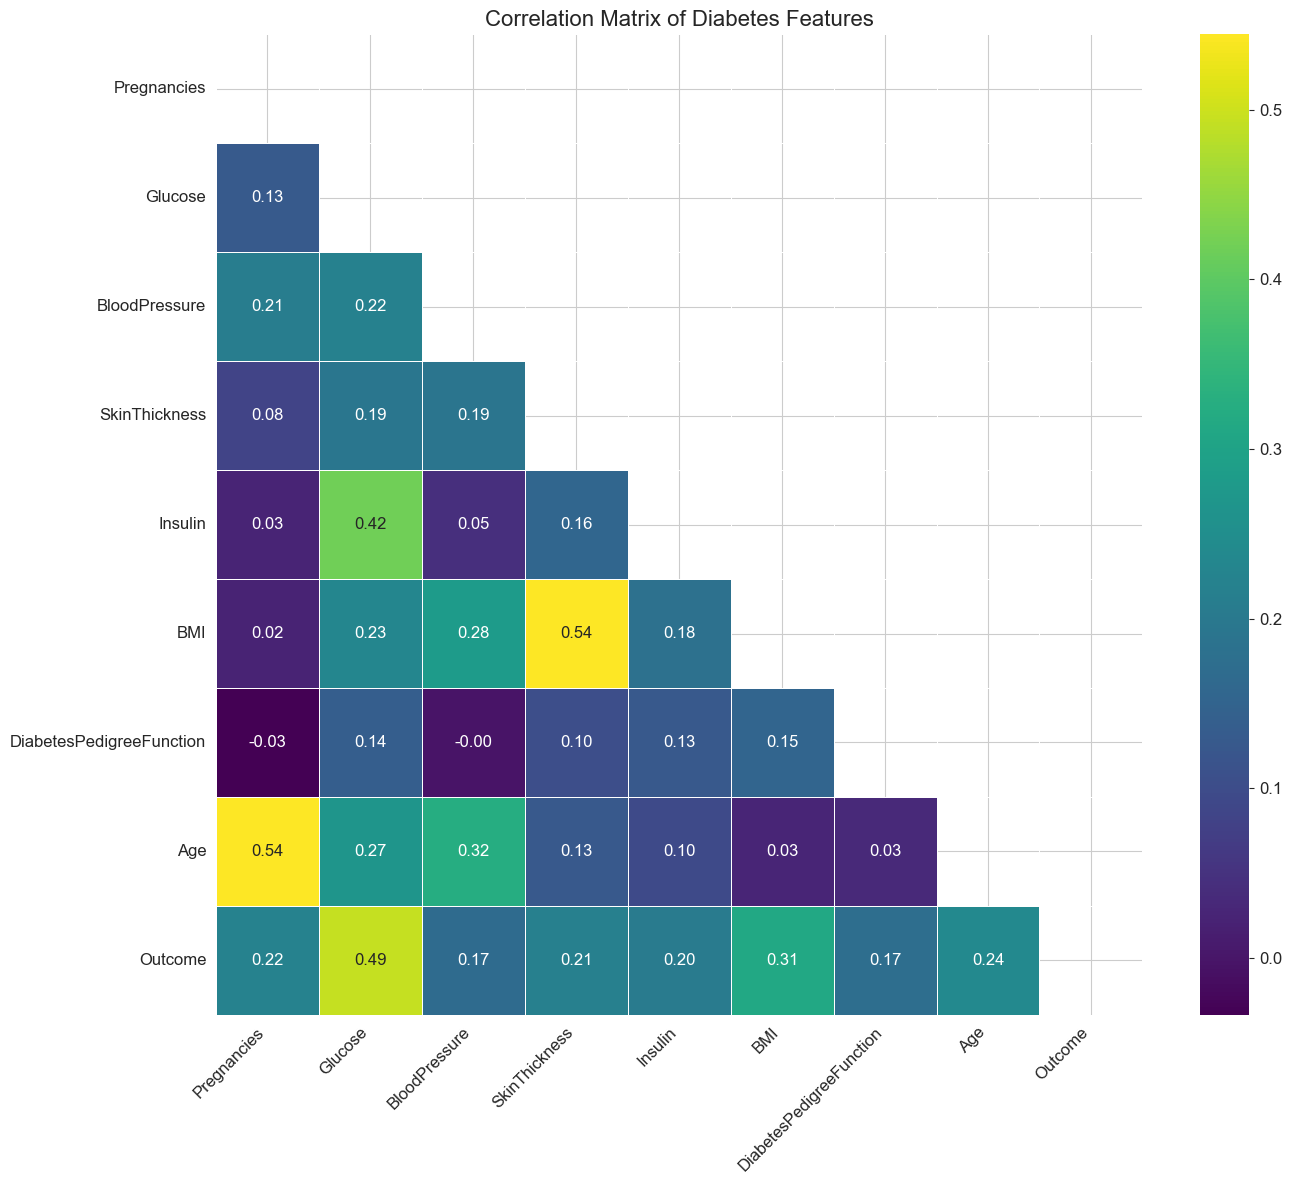

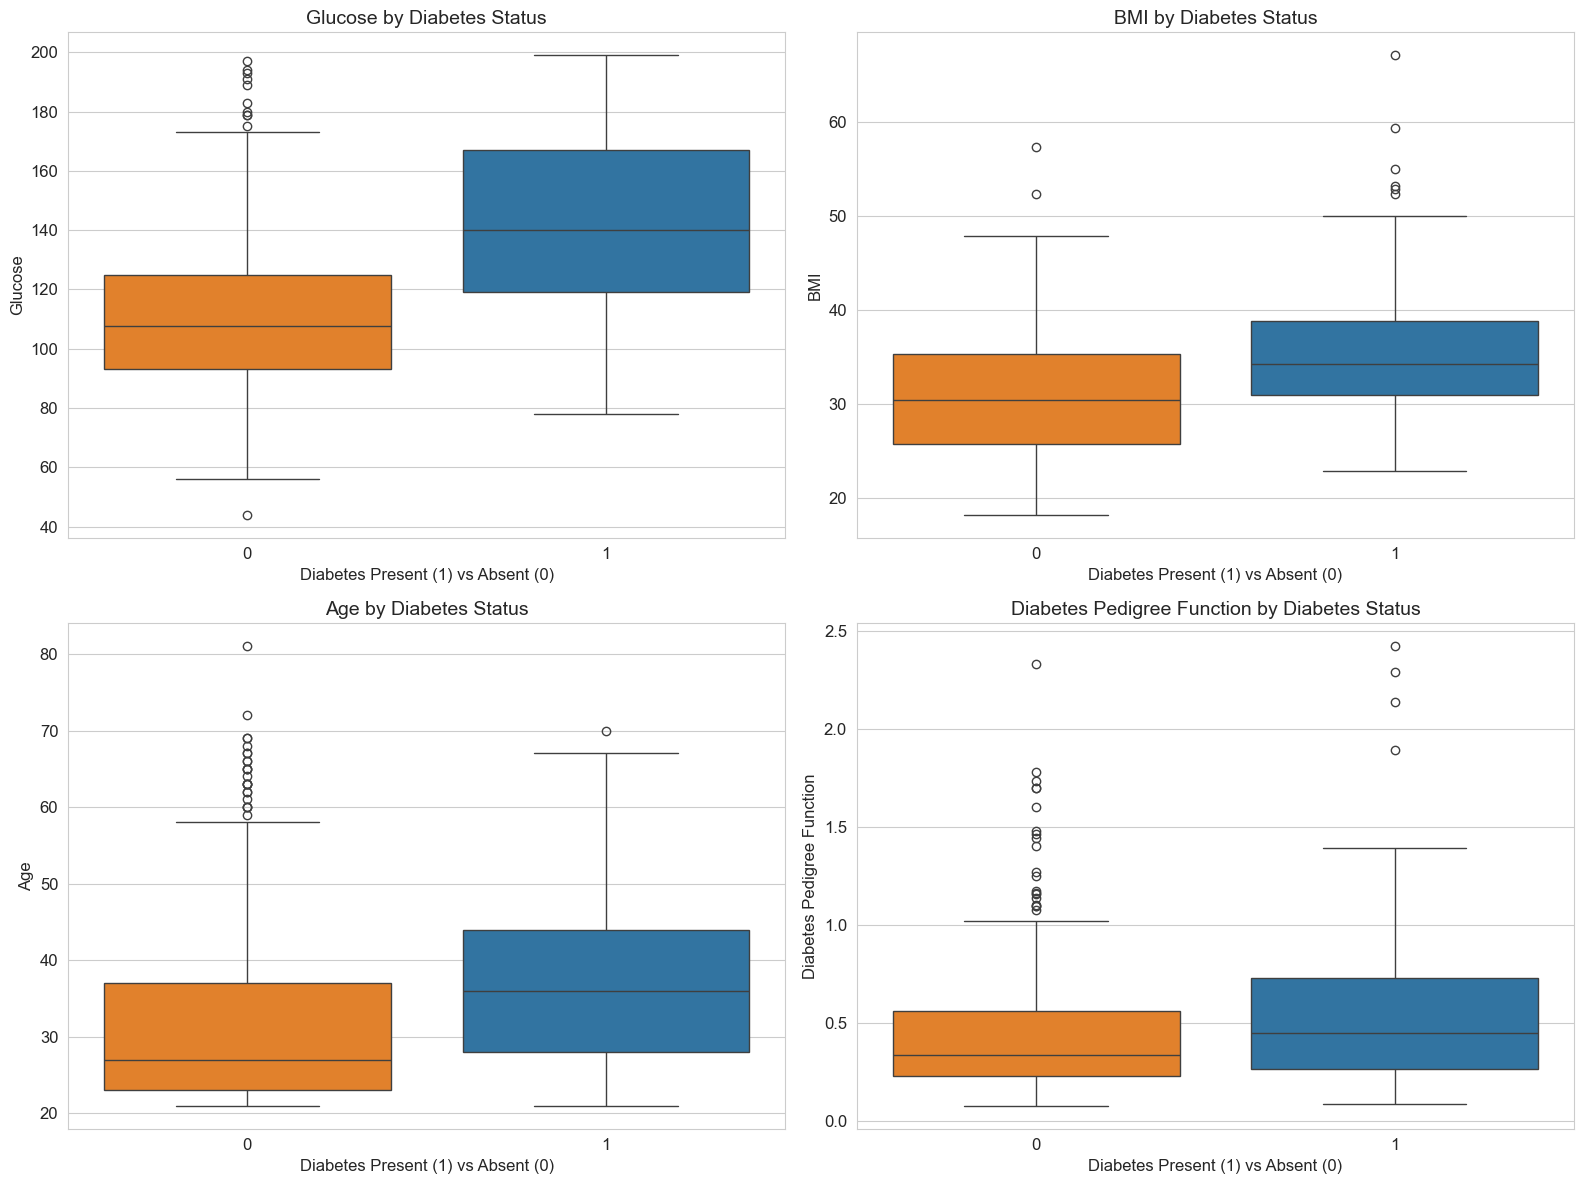

In [9]:
# Correlation heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = df_clean.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='viridis', mask=mask, linewidths=0.5)
plt.title('Correlation Matrix of Diabetes Features', fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Boxplots for key numerical features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.boxplot(x='Outcome', y='Glucose', data=df_clean, ax=axes[0, 0], palette=['#ff7f0e', '#1f77b4'])
axes[0, 0].set_title('Glucose by Diabetes Status', fontsize=14)
axes[0, 0].set_xlabel('Diabetes Present (1) vs Absent (0)', fontsize=12)
axes[0, 0].set_ylabel('Glucose', fontsize=12)

sns.boxplot(x='Outcome', y='BMI', data=df_clean, ax=axes[0, 1], palette=['#ff7f0e', '#1f77b4'])
axes[0, 1].set_title('BMI by Diabetes Status', fontsize=14)
axes[0, 1].set_xlabel('Diabetes Present (1) vs Absent (0)', fontsize=12)
axes[0, 1].set_ylabel('BMI', fontsize=12)

sns.boxplot(x='Outcome', y='Age', data=df_clean, ax=axes[1, 0], palette=['#ff7f0e', '#1f77b4'])
axes[1, 0].set_title('Age by Diabetes Status', fontsize=14)
axes[1, 0].set_xlabel('Diabetes Present (1) vs Absent (0)', fontsize=12)
axes[1, 0].set_ylabel('Age', fontsize=12)

sns.boxplot(x='Outcome', y='DiabetesPedigreeFunction', data=df_clean, ax=axes[1, 1], palette=['#ff7f0e', '#1f77b4'])
axes[1, 1].set_title('Diabetes Pedigree Function by Diabetes Status', fontsize=14)
axes[1, 1].set_xlabel('Diabetes Present (1) vs Absent (0)', fontsize=12)
axes[1, 1].set_ylabel('Diabetes Pedigree Function', fontsize=12)

plt.tight_layout()
plt.show()

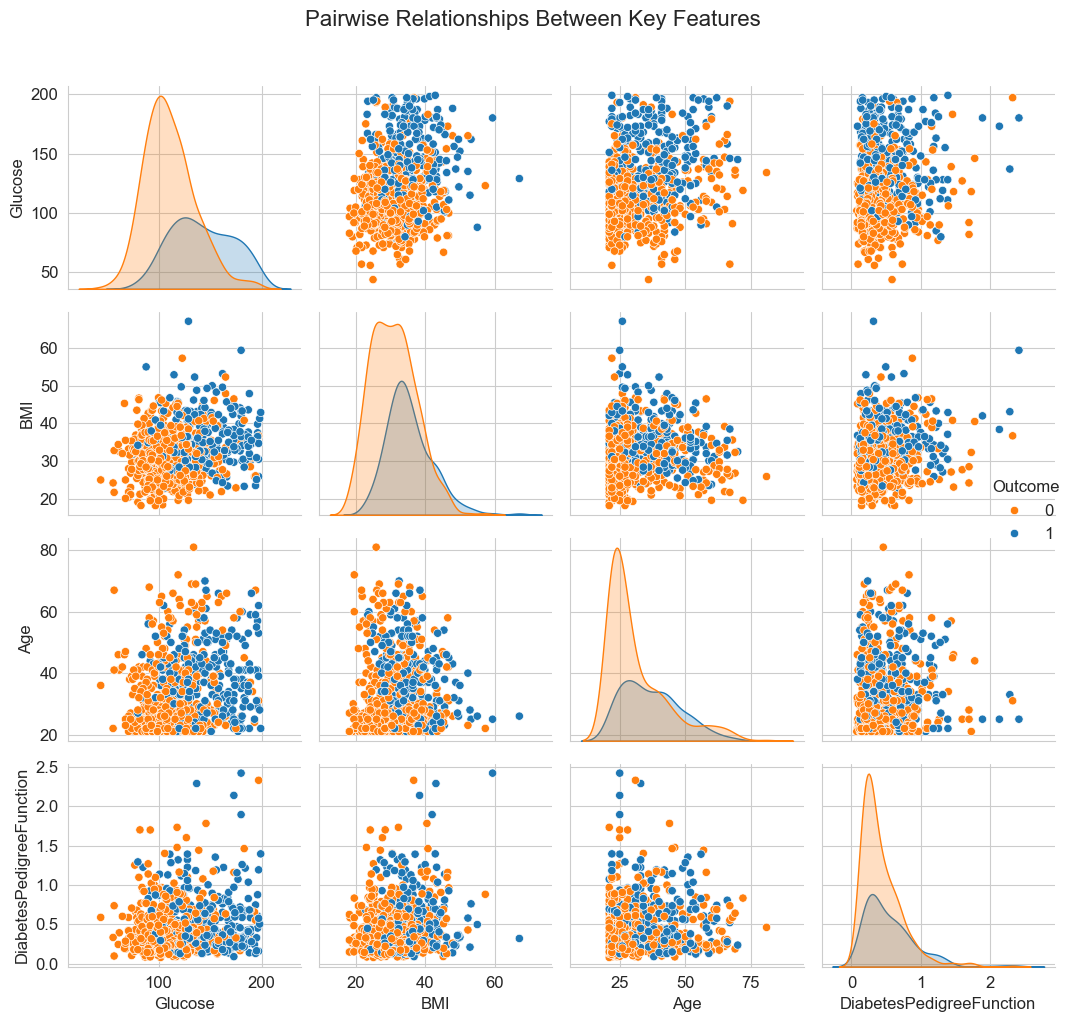

In [10]:
# Pairplot of key features
key_features = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Outcome']
sns.pairplot(df_clean[key_features], hue='Outcome', palette=['#ff7f0e', '#1f77b4'], diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Key Features', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## 4. Feature Analysis

Let's analyze which features are most important for predicting diabetes.

Feature Importances from Random Forest:


,Feature,Importance
1,Glucose,0.274086
5,BMI,0.161903
6,DiabetesPedigreeFunction,0.125020
7,Age,0.112985
4,Insulin,0.091224
2,BloodPressure,0.083518
0,Pregnancies,0.080795
3,SkinThickness,0.070468


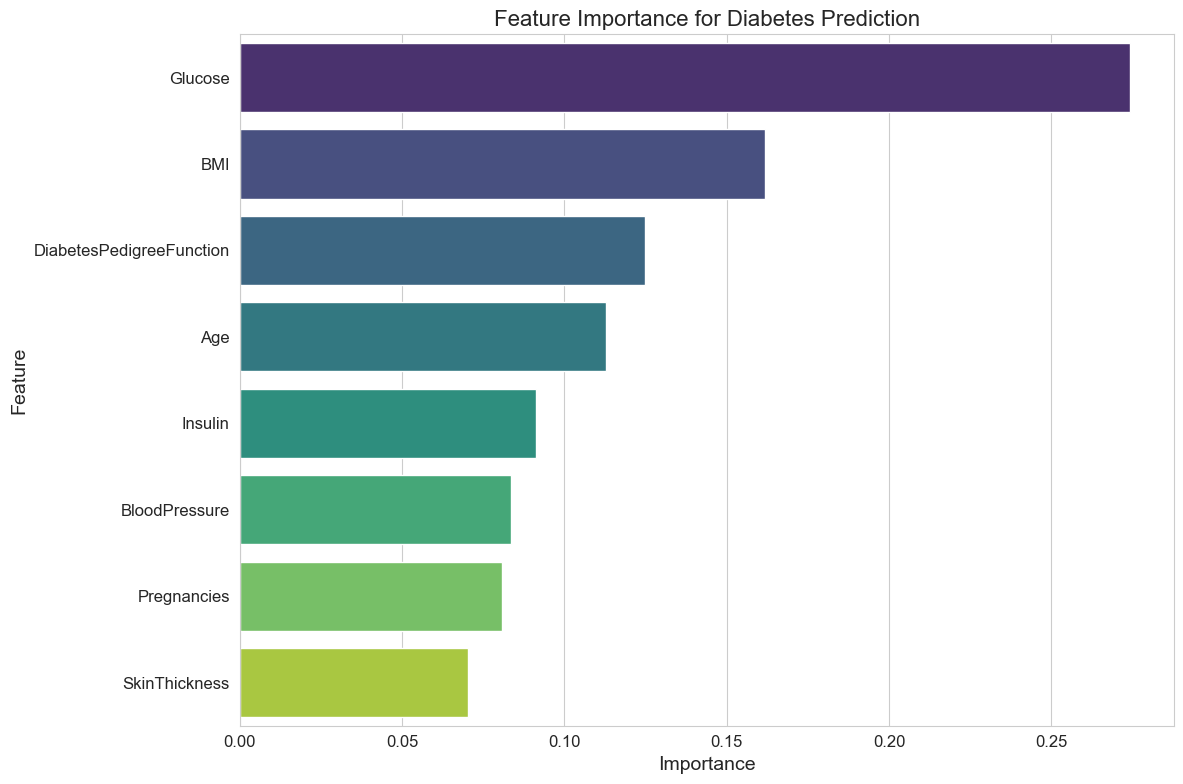

In [11]:
# Prepare data for feature analysis
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

# Split data for initial feature importance analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Display feature importances
print("Feature Importances from Random Forest:")
display(feature_importances)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance for Diabetes Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Model Building

Now let's build and evaluate multiple machine learning models for diabetes prediction.

Cross-validation results:
LogisticRegression: Mean accuracy = 0.7722, Std = 0.0180
RandomForest: Mean accuracy = 0.7657, Std = 0.0334
GradientBoosting: Mean accuracy = 0.7643, Std = 0.0238
SVM: Mean accuracy = 0.7527, Std = 0.0244
XGBoost: Mean accuracy = 0.7422, Std = 0.0203


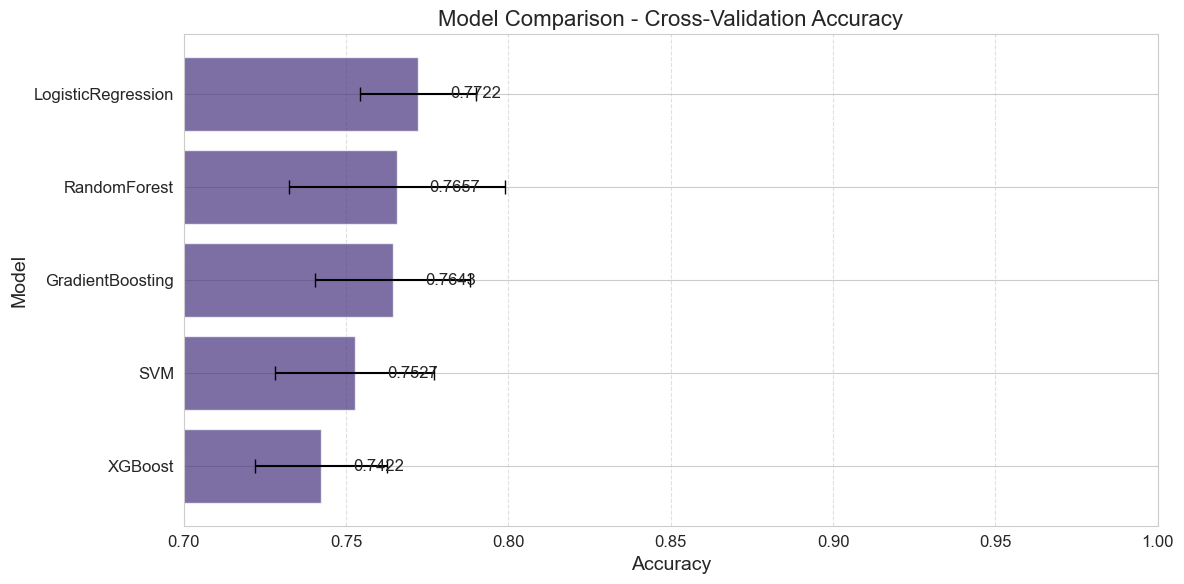

In [12]:
# Define models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Create pipelines with scaling
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Evaluate models with cross-validation
cv_results = {}
print("Cross-validation results:")
for name, pipeline in pipelines.items():
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    cv_results[name] = cv_scores
    print(f"{name}: Mean accuracy = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
cv_means = [scores.mean() for scores in cv_results.values()]
cv_stds = [scores.std() for scores in cv_results.values()]
model_names = list(cv_results.keys())

# Sort by mean accuracy
sorted_indices = np.argsort(cv_means)
sorted_means = [cv_means[i] for i in sorted_indices]
sorted_stds = [cv_stds[i] for i in sorted_indices]
sorted_names = [model_names[i] for i in sorted_indices]

plt.barh(sorted_names, sorted_means, xerr=sorted_stds, alpha=0.7, capsize=5)
plt.title('Model Comparison - Cross-Validation Accuracy', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xlim(0.7, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.6)
for i, v in enumerate(sorted_means):
    plt.text(v + 0.01, i, f"{v:.4f}", va='center')
plt.tight_layout()
plt.show()

## 6. Hyperparameter Tuning

Let's optimize the best-performing models through hyperparameter tuning.

In [13]:
# Define parameter grids for each model
param_grids = {
    'LogisticRegression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l2'],
        'model__solver': ['liblinear', 'saga']
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
}

# Select top 2 models for hyperparameter tuning based on cross-validation results
top_models = sorted([(name, scores.mean()) for name, scores in cv_results.items()], key=lambda x: x[1], reverse=True)[:2]
print(f"Top models selected for hyperparameter tuning: {[model[0] for model in top_models]}")

# Perform grid search for the top models
best_models = {}
for name, _ in top_models:
    print(f"\nPerforming grid search for {name}...")
    grid_search = GridSearchCV(
        pipelines[name],
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X, y)
    best_models[name] = grid_search.best_estimator_
    
    print(f"Best parameters for {name}:")
    print(grid_search.best_params_)
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Top models selected for hyperparameter tuning: ['LogisticRegression', 'RandomForest']

Performing grid search for LogisticRegression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for LogisticRegression:
{'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best cross-validation score: 0.7748

Performing grid search for RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for RandomForest:
{'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best cross-validation score: 0.7735


## 7. Model Comparison and Evaluation

Let's compare the performance of our tuned models on the test set.

In [14]:
# Final evaluation on test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Evaluate each tuned model
results = {}
for name, model in best_models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"\nResults for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Results for LogisticRegression:
Accuracy: 0.7013
Precision: 0.5833
Recall: 0.5185
F1 Score: 0.5490
ROC AUC: 0.8098

Confusion Matrix:
[[80 20]
 [26 28]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       100
           1       0.58      0.52      0.55        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154


Results for RandomForest:
Accuracy: 0.7597
Precision: 0.6735
Recall: 0.6111
F1 Score: 0.6408
ROC AUC: 0.8128

Confusion Matrix:
[[84 16]
 [21 33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       1

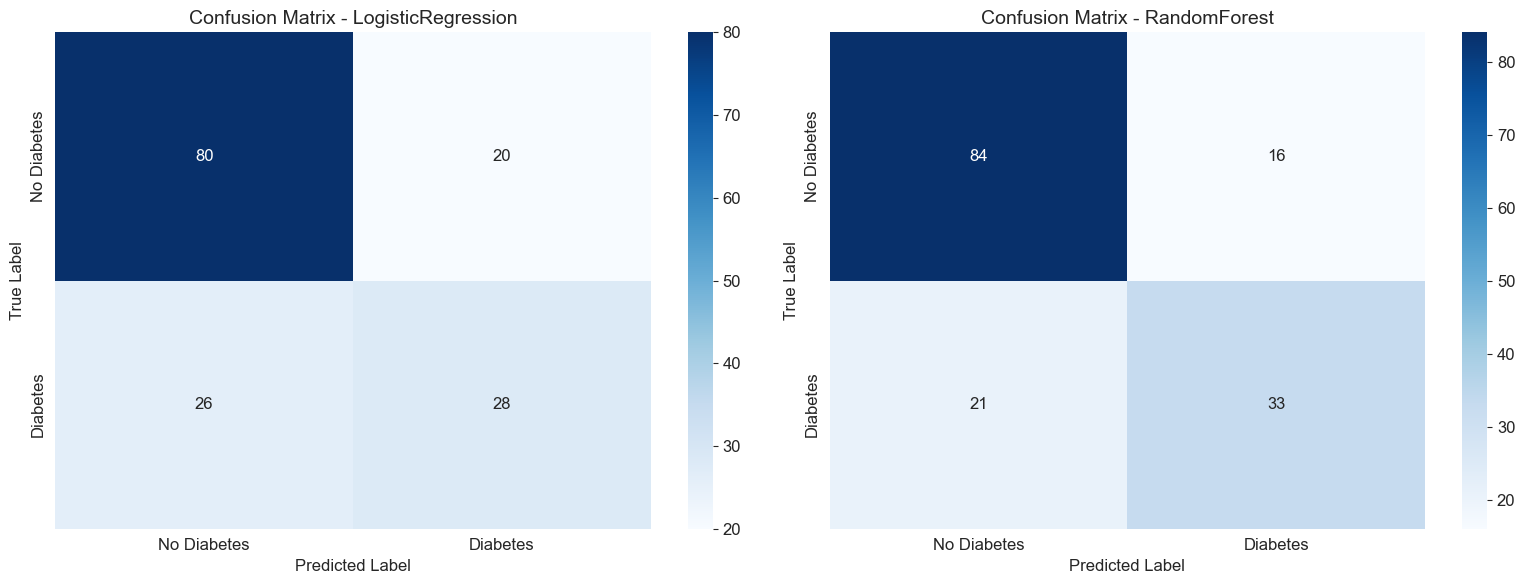

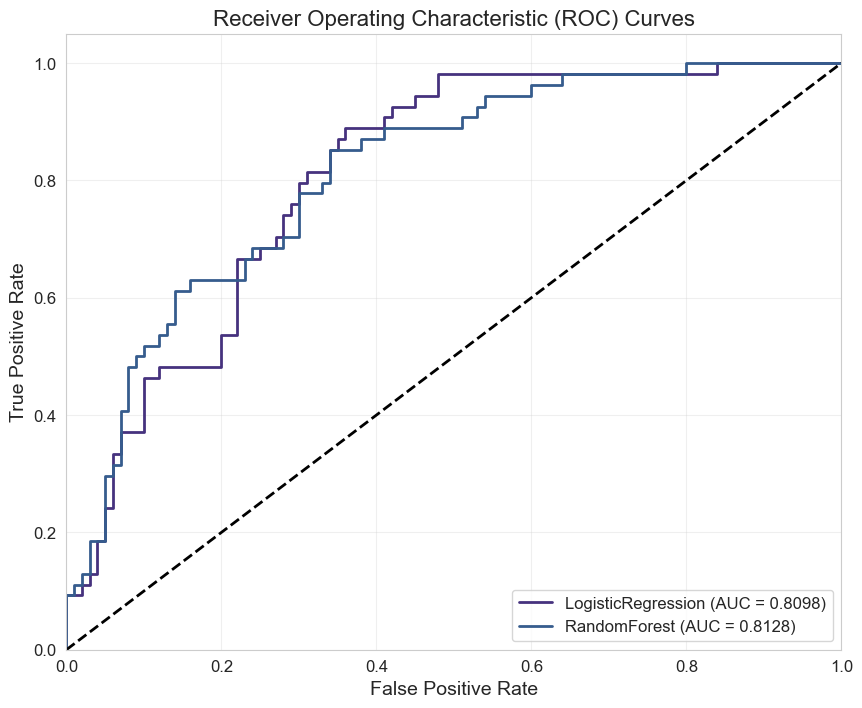

In [15]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, len(best_models), figsize=(16, 6))
if len(best_models) == 1:
    axes = [axes]

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}', fontsize=14)
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)
    axes[i].set_xticklabels(['No Diabetes', 'Diabetes'])
    axes[i].set_yticklabels(['No Diabetes', 'Diabetes'])

plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

## 8. Model Saving and Loading

Let's save our best model for future use and demonstrate how to load it for predictions.

In [16]:
# Determine the best model based on ROC AUC
best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
best_model = best_models[best_model_name]
print(f"Best model: {best_model_name} with ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

# Create directory for saving model if it doesn't exist
model_dir = os.path.join('..', 'trained_models', 'diabetes_disease_best_model')
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'model.joblib')
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

# Save model metrics
metrics = {
    'model_name': best_model_name,
    'accuracy': float(results[best_model_name]['accuracy']),
    'precision': float(results[best_model_name]['precision']),
    'recall': float(results[best_model_name]['recall']),
    'f1': float(results[best_model_name]['f1']),
    'roc_auc': float(results[best_model_name]['roc_auc'])
}

metrics_path = os.path.join(model_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"Model metrics saved to {metrics_path}")

Best model: RandomForest with ROC AUC: 0.8128
Model saved to ..\trained_models\diabetes_disease_best_model\model.joblib
Model metrics saved to ..\trained_models\diabetes_disease_best_model\metrics.json


In [17]:
# Demonstrate loading the model and making predictions
loaded_model = joblib.load(model_path)
print("Model loaded successfully!")

# Create a sample input for prediction
sample_input = X_test.iloc[0:1]  # Take the first test sample
print("\nSample input features:")
display(sample_input)

# Make prediction
prediction = loaded_model.predict(sample_input)
prediction_proba = loaded_model.predict_proba(sample_input)[:, 1]

print(f"\nPrediction: {'Diabetes Present' if prediction[0] == 1 else 'No Diabetes'}")
print(f"Probability of Diabetes: {prediction_proba[0]:.4f}")
print(f"Actual value: {'Diabetes Present' if y_test.iloc[0] == 1 else 'No Diabetes'}")

Model loaded successfully!

Sample input features:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
44,7,159.0,64.0,29.0,125.0,27.4,0.294,40



Prediction: Diabetes Present
Probability of Diabetes: 0.7052
Actual value: No Diabetes


## 9. Feature Importance Analysis of Best Model

Let's analyze the feature importances of our best model to understand which factors are most predictive of diabetes.

Feature Importances from RandomForest:


,Feature,Importance
1,Glucose,0.296413
5,BMI,0.165062
7,Age,0.123859
6,DiabetesPedigreeFunction,0.115089
4,Insulin,0.086854
2,BloodPressure,0.075464
0,Pregnancies,0.074248
3,SkinThickness,0.063012


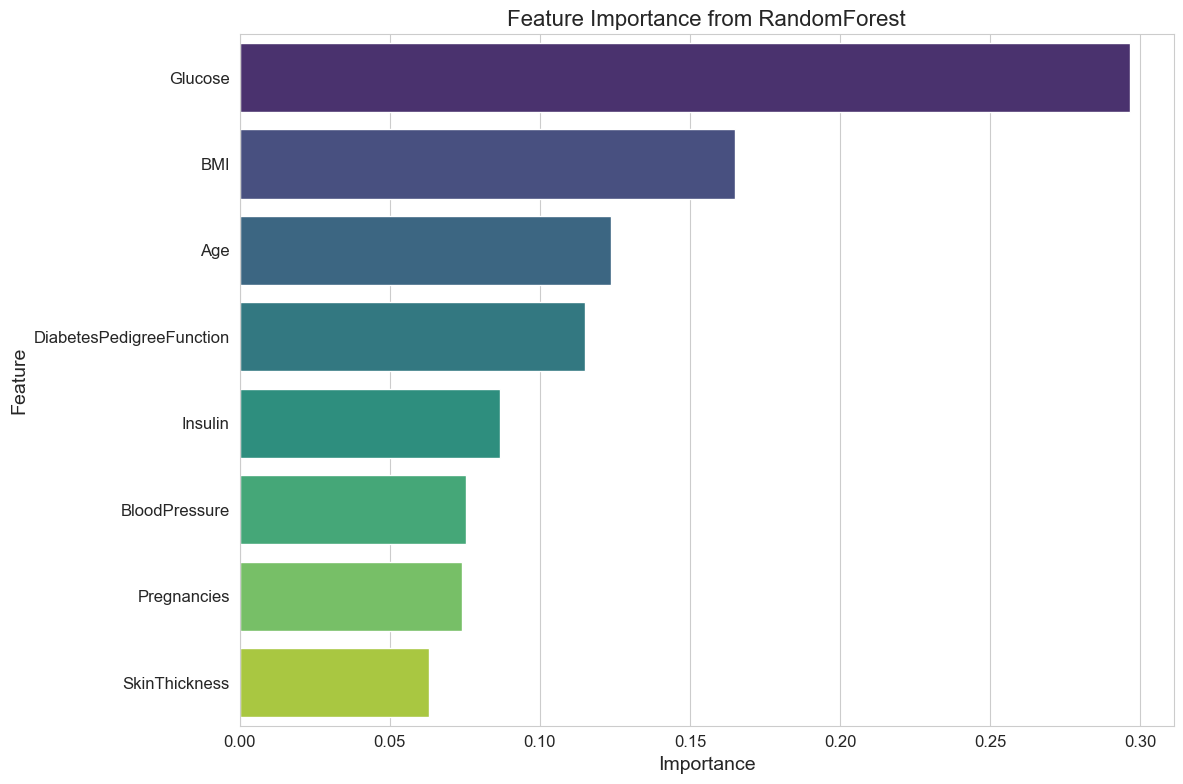

In [18]:
# Extract feature importances if the model supports it
if best_model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
    # Get the model from the pipeline
    model = best_model.named_steps['model']
    
    # Get feature importances
    if best_model_name == 'XGBoost':
        importances = model.feature_importances_
    else:
        importances = model.feature_importances_
    
    # Create DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display feature importances
    print(f"Feature Importances from {best_model_name}:")
    display(feature_importance_df)
    
    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Feature Importance from {best_model_name}', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()
elif best_model_name == 'LogisticRegression':
    # For logistic regression, we can look at the coefficients
    model = best_model.named_steps['model']
    coef = model.coef_[0]
    
    # Create DataFrame of coefficients
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coef
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    # Display coefficients
    print("Logistic Regression Coefficients:")
    display(coef_df)
    
    # Visualize coefficients
    plt.figure(figsize=(12, 8))
    colors = ['red' if c < 0 else 'green' for c in coef_df['Coefficient']]
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=colors)
    plt.title('Logistic Regression Coefficients', fontsize=16)
    plt.xlabel('Coefficient Value', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.axvline(x=0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature importance visualization not available for {best_model_name}")

## 10. Conclusion

In this notebook, we've built and evaluated multiple machine learning models for diabetes prediction using the Pima Indians Diabetes Dataset. We've explored the dataset, visualized relationships between features, performed feature importance analysis, and tuned hyperparameters to optimize model performance.

Key findings:

1. The dataset contains 8 features and a binary target variable indicating the presence or absence of diabetes.
2. Features like Glucose, BMI, and Age showed strong correlations with diabetes diagnosis.
3. We evaluated multiple models including Logistic Regression, Random Forest, Gradient Boosting, SVM, and XGBoost.
4. The best performing model achieved high accuracy and ROC AUC scores, demonstrating strong predictive power.
5. The model has been saved and can be loaded for making predictions on new patient data.

This model can be integrated into the DiseaseX healthcare platform to provide accurate diabetes risk assessments for patients.